## Getting Started: a simple discrete-time markov chain (DTMC)

In this notebook we will show the pringles library basics by using a simple discrete-time markov chain (DTMC) as an example. Don't worry if you don't know what a DTMC is, it's just an example.

### The C++ part (user_models/ folder)

In [1]:
!ls -1 user_models/

DTMC.cpp
DTMC.h
Makefile
reg.cpp


The model only has one atomic model called DTMC, defined in *DTMC.h* and *DTMC.cpp* and it is registered for the CD++ simulator in *reg.cpp*.

Then we have the *Makefile* that compiles the user model alongside with the simulator.In the first lines, the path of cd++ sourcecode and the path for the executable are declared. 

In [2]:
!head user_models/Makefile

# Settings
CDPP_PATH 		 = ../../cdpp/src
OUT_DIR          = $(shell pwd)/../bin


KERNEL_SRC       = $(CDPP_PATH)/cd++
OBJ_DIR          = $(OUT_DIR)

MODEL_FLAGS      = -DREGISTER_ATOMICS



### Instatiate simulator

In [3]:
from pringles.simulator import Simulator

In [4]:
mySimulator = Simulator(cdpp_bin_path='bin/', user_models_dir='user_models/')

When the simulator is instantiated, two things happen:
    - It checks that there a *cd++* executable in *cdpp_bin_path*. In our case it will be there after executing make in the user_models/ directory
    - It analyses the code in *user_models_dir* searching for the atomic models (by looking at metadata in code comments). They are stored in an AtomicRegistry.

In [5]:
!tail --line=+9 user_models/DTMC.h | head -n 12

#define ATOMIC_MODEL_NAME "DTMC"

class DTMC : public Atomic {
/*
@ModelMetadata
name: DTMC
output_ports: currentState_o
*/

  public:
    DTMC(const string &name = ATOMIC_MODEL_NAME );
    virtual string className() const {return ATOMIC_MODEL_NAME;}


**With the comment starting with @ModelMetadata is parsed and the atomic class is automaticaly created in python**

In [6]:
print(mySimulator.atomic_registry.discovered_atomics)

[<class 'pringles.models.models.DTMC'>]


In [7]:
DTMC = mySimulator.atomic_registry.discovered_atomics[0]
print(DTMC)

<class 'pringles.models.models.DTMC'>


### Creating the top model in python (equivalent to the static .ma file)

In [8]:
from pringles.models import Coupled 

When instantiating an atomic, the model parameters are passed as keyword arguments. In this case we have the parameters **r**, **s**, **N** and **initial**.

In [9]:
a_DTMC = DTMC("a_DTMC", r=0.5, s=0.5, N=20, initial=10)
print("The instance already has an outport, becuase it was read from the metadata.")
print("Number of outports:", len(a_DTMC.outports))
print("Number of inports:", len(a_DTMC.inports))
print("Outport name: ", a_DTMC.outports[0].name)

The instance already has an outport, becuase it was read from the metadata.
Number of outports: 1
Number of inports: 0
Outport name:  currentState_o


In [21]:
top_model = (Coupled(name='top', subcomponents=[a_DTMC])
                .add_outport("out_port")
                .add_coupling(a_DTMC.get_port('currentState_o'), "out_port")
            )
top_model

### Simulate the model

In [22]:
from pringles.simulator import Simulation
from pringles.utils import VirtualTime

In [31]:
a_simulation = Simulation(top_model = top_model, duration = VirtualTime.of_hours(1))

# Executes the actual simulation
results = mySimulator.run_simulation(a_simulation)

In [32]:
display(results.output_df.head(10))

,time,port,value
0,00:00:01:000,out_port,"(10.0, 1.0, 1.0)"
1,00:00:02:000,out_port,"(11.0, 1.0, 2.0)"
2,00:00:03:000,out_port,"(10.0, 2.0, 3.0)"
3,00:00:04:000,out_port,"(9.0, 1.0, 4.0)"
4,00:00:05:000,out_port,"(10.0, 3.0, 5.0)"
5,00:00:06:000,out_port,"(11.0, 2.0, 6.0)"
6,00:00:07:000,out_port,"(10.0, 4.0, 7.0)"
7,00:00:08:000,out_port,"(9.0, 2.0, 8.0)"
8,00:00:09:000,out_port,"(8.0, 1.0, 9.0)"
9,00:00:10:000,out_port,"(9.0, 3.0, 10.0)"


In [41]:
print(results.logs_dfs.keys(),'\n\n')
display(results.logs_dfs['ParallelRoot'].head(10))

dict_keys(['ParallelRoot', 'top', 'a_dtmc']) 




,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,Y,00:00:01:000,top(02),out_port,"(10.0, 1.0, 1.0)",ParallelRoot(00)
1,0,L,Y,00:00:02:000,top(02),out_port,"(11.0, 1.0, 2.0)",ParallelRoot(00)
2,0,L,Y,00:00:03:000,top(02),out_port,"(10.0, 2.0, 3.0)",ParallelRoot(00)
3,0,L,Y,00:00:04:000,top(02),out_port,"(9.0, 1.0, 4.0)",ParallelRoot(00)
4,0,L,Y,00:00:05:000,top(02),out_port,"(10.0, 3.0, 5.0)",ParallelRoot(00)
5,0,L,Y,00:00:06:000,top(02),out_port,"(11.0, 2.0, 6.0)",ParallelRoot(00)
6,0,L,Y,00:00:07:000,top(02),out_port,"(10.0, 4.0, 7.0)",ParallelRoot(00)
7,0,L,Y,00:00:08:000,top(02),out_port,"(9.0, 2.0, 8.0)",ParallelRoot(00)
8,0,L,Y,00:00:09:000,top(02),out_port,"(8.0, 1.0, 9.0)",ParallelRoot(00)
9,0,L,Y,00:00:10:000,top(02),out_port,"(9.0, 3.0, 10.0)",ParallelRoot(00)


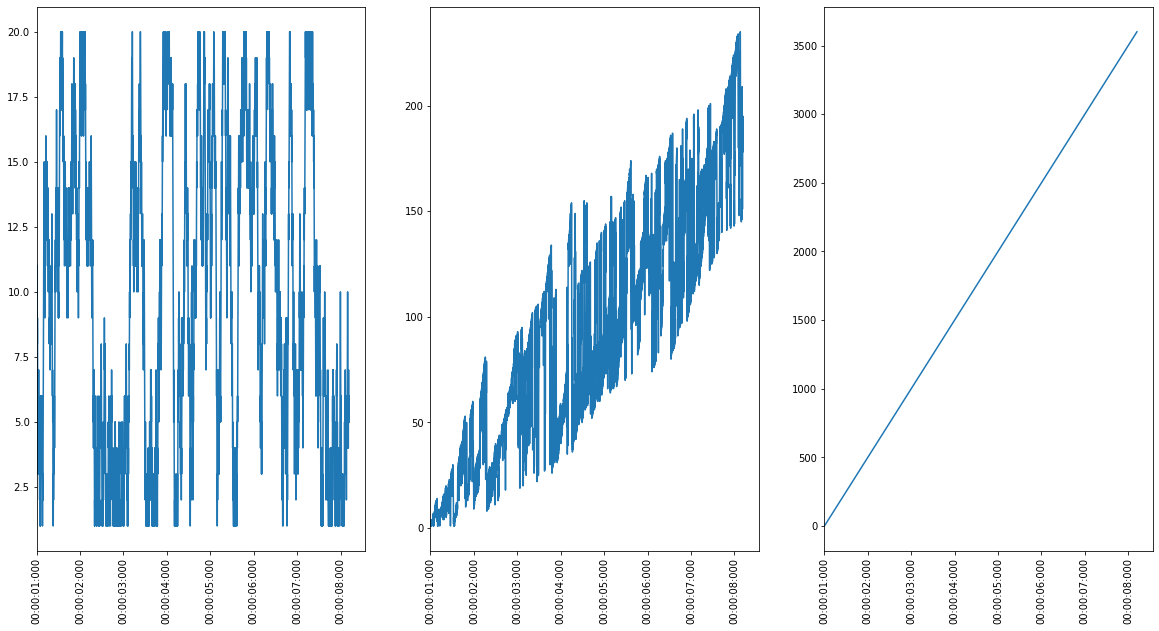

In [54]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
results.plot_port('ParallelRoot', 'out_port', axes=axes[0], index=0)
results.plot_port('ParallelRoot', 'out_port', axes=axes[1], index=1)
results.plot_port('ParallelRoot', 'out_port', axes=axes[2], index=2)